In [1]:
%%capture

%pip install numpy ollama langchain_text_splitters python-dotenv pandas psycopg2-binary Jinja2

Let's get our imports out of the way.

In [1]:
import json
import os.path
from os import listdir
from os.path import isfile, join
import re
from ollama import Client
import time
import numpy as np
from langchain_text_splitters import RecursiveCharacterTextSplitter #Importing this to show chunks
from dotenv import load_dotenv
from pathlib import Path
import re
import psycopg2
from dotenv import load_dotenv
import os

import db_methods as db
import model_methods as mdl

In [2]:
load_dotenv()
OLLAMA_HOST=os.environ.get("OLLAMA_HOST")
DB_String=os.environ.get("DATABASE_CONNECTION_STRING")

In [4]:
def connect_db():
    return psycopg2.connect(DB_String)

# Create the table
def create_table(tablename):
    with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute(f"""
                           CREATE TABLE IF NOT EXISTS {tablename} (
                                id          BIGINT PRIMARY KEY GENERATED BY DEFAULT AS IDENTITY,
                                filename    TEXT,
                                meta_data   JSON,
                                author      TEXT,
                                title       TEXT NOT NULL,
                                text        TEXT NOT NULL
                                )
                            """)

# Create the embedding table
def create_embedding_table(tablename, embedding_model, embedding_ctx_size, chunk_size, chunk_overlap):
    model = embedding_model.replace('-', '_')
    with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute(f"""
                            SELECT ai.create_vectorizer(
                                '{tablename}'::regclass,
                                    destination => '{tablename}_{model}_{chunk_size}',
                                    embedding => ai.embedding_ollama('{embedding_model}', {embedding_ctx_size}),
                                    chunking => ai.chunking_recursive_character_text_splitter('text', {chunk_size}, {chunk_overlap}, separators => array[E'\n;', ' '])
                                )
                            """)

def drop_text_tables(tablename):
     with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute(f"DROP TABLE {tablename} CASCADE;")
                     
# Install the ai extension and its dependencies
with connect_db() as connection:
    with connection.cursor() as cursor:
            cursor.execute("""
                        CREATE EXTENSION IF NOT EXISTS ai CASCADE;
                        """)


Now, load some data into the **texts** table

In [5]:
class Text:
    def __init__(self, filename):
        self.title = re.match(r".+\\(.+)\.txt$", filename).group(1)
        self.author = re.match(r".+\\(\w+)\\.+.txt", filename).group(1)
        self.filename = f"{self.author}-{self.title}"
        self.metadata = {
            "author": self.author,
            "title": self.title,
            "filename": self.filename
            }
        with open(filename, encoding="utf-8-sig") as f:
            file_contents = f.read()
            self.contents = re.sub(r'[^\S\r\n]+', " ", file_contents)
        

def load_directory(dirname, filter):
    return list(Path(dirname).rglob(filter))

# This method has an intentional lazy flaw in that if a record is already in the database, we just leave it alone for now.
def add_text_record(_text, tablename):
    print(_text.metadata)
    with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute(f"SELECT filename from {tablename} where filename = %s", [_text.filename])
            if(len(cursor.fetchall()) == 0):
                meta_data = json.dumps(_text.metadata)
                print(f"Adding file: {meta_data}\n")
                cursor.execute(f"INSERT into {tablename} (filename, author, title, meta_data, text)" \
                "VALUES (%s, %s, %s, %s, %s)", (_text.filename, _text.author, _text.title, meta_data, _text.contents))

Now that we've initialized all the methods we'll be using, let's identify some embedding models and generative models.

In [6]:
embedding_models = [
                        {
                            "modelname": "nomic-embed-text",
                            "context_size": 768,
                            "chunk_size": 500,
                            "overlap_size": 20
                        },
                        {
                            "modelname": "nomic-embed-text",
                            "context_size": 768,
                            "chunk_size": 300,
                            "overlap_size": 15
                        },
                        {
                            "modelname": "nomic-embed-text",
                            "context_size": 768,
                            "chunk_size": 200,
                            "overlap_size": 10
                        }
                    ]
    


In [7]:
content_directory = "texts"

create_table(content_directory)

# When you're done, you can clean up after yourself to save some space.
# drop_text_tables(content_directory)

In [8]:
files = load_directory(content_directory, "*.txt")

# Modify this     v    to limit how many texts to vectorize
for file in files:
    text = Text(str(file))
    # We aren't creating an array of Text objects because it could consume an
    # outrageous amount of memory if there are tons of texts.
    add_text_record(text, content_directory)

{'author': 'barrie', 'title': 'peterpan', 'filename': 'barrie-peterpan'}
Adding file: {"author": "barrie", "title": "peterpan", "filename": "barrie-peterpan"}

{'author': 'paltock', 'title': 'peter_wilkins', 'filename': 'paltock-peter_wilkins'}
Adding file: {"author": "paltock", "title": "peter_wilkins", "filename": "paltock-peter_wilkins"}

{'author': 'stoker', 'title': 'dracula', 'filename': 'stoker-dracula'}
Adding file: {"author": "stoker", "title": "dracula", "filename": "stoker-dracula"}

{'author': 'shakespeare', 'title': "a lover's complaint", 'filename': "shakespeare-a lover's complaint"}
Adding file: {"author": "shakespeare", "title": "a lover's complaint", "filename": "shakespeare-a lover's complaint"}

{'author': 'shakespeare', 'title': "all's well that ends well", 'filename': "shakespeare-all's well that ends well"}
Adding file: {"author": "shakespeare", "title": "all's well that ends well", "filename": "shakespeare-all's well that ends well"}

{'author': 'shakespeare', 't

In [9]:
create_embedding_table(content_directory, "nomic-embed-text", 768, 500, 30)

In [10]:
create_embedding_table(content_directory, "nomic-embed-text", 768, 300, 15)

In [11]:
create_embedding_table(content_directory, "nomic-embed-text", 768, 200, 10)

Let's talk a bit about *Vectorization*

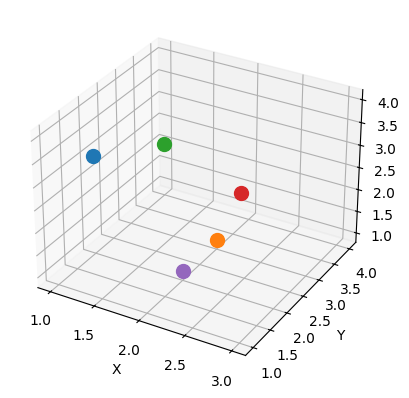

In [5]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Sample discrete data
# x = np.array([1, 2, 1, 2, 1, 2])
# y = np.array([3, 3, 4, 4, 5, 5])
# z = np.array([6, 7, 8, 9, 7, 9])
# colors = np.array([0, 1, 0, 1, 0, 1]) # Assign colors based on a category
# markers = np.array(["o", "^", "o", "^", "o", "^"]) #Assign markers based on a category

# # Create the figure and 3D axes
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Scatter plot
# for i in range(len(x)):
#     ax.scatter(x[i], y[i], z[i], c=[colors[i]], marker=markers[i], s=100)

# # Set labels
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Z-axis')

# # Set ticks to be integers only
# ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax.zaxis.set_major_locator(plt.MaxNLocator(integer=True))

# # Show the plot
# plt.title('3D Scatter Plot of Discrete Data')
# plt.show()

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import imread
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import numpy as np

# Sample discrete data
x = np.array([1, 2, 1, 3, 2])
y = np.array([2, 3, 4, 1, 2])
z = np.array([3, 1, 2, 4, 1])
categories = np.array(['A', 'B', 'A', 'C', 'B'])

# Load image markers
marker_images = {
    'A': imread('images/marker_a.png'),
    'B': imread('images/marker_b.png'),
    'C': imread('images/marker_c.png'),
}

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data points with image markers
for i in range(len(x)):
    category = categories[i]
    image = marker_images[category]
    
    # Create an annotation box for the image
    ab = AnnotationBbox(OffsetImage(image, zoom=0.2), (x[i], y[i]), frameon=False)
    # ax.add_artist(ab)
    ax.scatter(x[i], y[i], z[i], marker='o', s=100) # Use a dummy scatter to set the 3d location

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show plot
plt.show()

In [ ]:
def gather_appropriate_chunks_by_author_metadata(author, prompt, count):
    with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute("""
                           SELECT 
                           chunk,
                           embedding <=> ai.ollama_embed('nomic-embed-text', %s) as distance
                           FROM texts_embeddings
                           WHERE author = %s
                           ORDER BY distance
                           LIMIT %s;
                           """, (prompt, author, count))
            return cursor.fetchall()    

def gather_appropriate_chunks_by_title_metadata(title, prompt, count):
    with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute("""
                           SELECT 
                           chunk,
                           embedding <=> ai.ollama_embed('nomic-embed-text', %s) as distance
                           FROM texts_embeddings //{tablename}_{model}_{chunk_size}
                           WHERE title = %s
                           ORDER BY distance
                           LIMIT %s;
                           """, (prompt, title, count))
            return cursor.fetchall() 

def gather_inappropriate_chunks(prompt, count):
    with connect_db() as connection:
        with connection.cursor() as cursor:
            cursor.execute("""
                           SELECT 
                           chunk,
                           embedding <=> ai.ollama_embed('nomic-embed-text', %s) as distance
                           FROM texts_embeddings
                           ORDER BY distance
                           LIMIT %s;
                           """, (prompt, count))
            return cursor.fetchall() 
            

In [13]:
client = Client(
    host='http://192.168.137.117:11434',
)
prompt_size=8000
chunking_size=500
chunk_count = prompt_size // chunking_size
embed_model = "nomic-embed-text"
generate_model = "gemma3:12b"
SYSTEM_PROMPT = """
You are a helpful reading assistant who answers questions
based on snippets of text provided in context. Answer only using the context provided,
being as concise as possible. If the answer isn't in the context, simply say so.
Context:
"""

def generate_response(prompt, most_similar_chunks, model):
    # client.pull(generate_model) # You really should pre-pull your models
    
    # most_similar_chunks = gather_inappropriate_chunks(prompt)
    # for item in most_similar_chunks:
    #     print(item[0])
    # print("\n\n\n")
    system_prompt = SYSTEM_PROMPT + "\n".join(item[0] for item in most_similar_chunks)
    # print(f"{system_prompt}\n\n")
    
    response = client.chat(
        model,
        messages = [
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        stream = True
    )
    return response

def stream_response(stream):
    for chunk in stream:
        print(chunk['message']['content'], end='', flush=True)

In [14]:
prompt = "who is peter and what was his role on the island?"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("peterpan", prompt, 14) # 14 seems to be the sweetspot. any more and you over-run the context buffer and bad things happen.
stream_response(generate_response(prompt, most_similar_chunks, generate_model))


UndefinedTable: relation "texts_embeddings" does not exist
LINE 5:                            FROM texts_embeddings
                                        ^


In [61]:
prompt = "who is peter and what was his role on the island?"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("peterpan", prompt, 2)
for chunk in most_similar_chunks:
    print(chunk)
print("---\n")
stream_response(generate_response(prompt, most_similar_chunks, generate_model))

('When last we saw him he was stealing across the\nisland with one finger to his lips and his dagger at the ready. He had\nseen the crocodile pass by without noticing anything peculiar about it,\nbut by and by he remembered that it had not been ticking. At first he\nthought this eerie, but soon concluded rightly that the clock had run\ndown.\n\nWithout giving a thought to what might be the feelings of a\nfellow-creature thus abruptly deprived of its closest companion, Peter\nbegan to consider how he could', 0.31846014408478407)
('did not compete. For one thing he despised all mothers except\nWendy, and for another he was the only boy on the island who could\nneither write nor spell; not the smallest word. He was above all that\nsort of thing.\n\nBy the way, the questions were all written in the past tense. What was\nthe colour of Mother’s eyes, and so on. Wendy, you see, had been\nforgetting, too.\n\nAdventures, of course, as we shall see, were of daily occurrence; but\nabout this time

In [62]:
prompt = "who is peter and what was his role on the island?"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("peterpan", prompt, 17)
stream_response(generate_response(prompt, most_similar_chunks, generate_model))


Okay, let's break down who Peter is and his incredibly complex role on the island in the TV series "Lost." **Be warned: this will contain major spoilers!**

**Who is Peter?**

Peter Labek (played by actor Hector Ramirez) is a seemingly ordinary man who lives on the island with his wife, Emily.  Initially, he's presented as a simple, somewhat hapless, and emotionally stunted individual. He's known for his awkwardness, his obsession with hunting, and his peculiar relationship with his wife.

However, Peter is *far* from ordinary. He's actually a crucial element in the island's existence and purpose. Here's the breakdown of his true identity:

*   **He is the Island's "Guardian":** Peter is not a native islander, but he was brought to the island by Jacob, one of the island's protectors, long before the crash of Oceanic Flight 815.
*   **He was created as a "Vessel":** Jacob discovered that Peter was a person with unique capabilities, most importantly an unusual level of physical resilienc

In [63]:
prompt = "who ate Dracula's food??"

most_similar_chunks = gather_inappropriate_chunks(prompt, 7)
for chunk in most_similar_chunks:
    print(chunk)
print("---\n") 
   
stream_response(generate_response(prompt, most_similar_chunks, generate_model))

("priest buy any soul with his money, he shall eat of it, and he that is born in his house: they shall eat of his meat. \nIf the priest's daughter also be married unto a stranger, she may not eat of an offering of the holy things. \nBut if the priest's daughter be a widow, or divorced, and have no child, and is returned unto her father's house, as in her youth, she shall eat of her father's meat: but there shall be no stranger eat thereof. \nAnd if a man eat of the holy thing unwittingly, then he", 0.3438387809356128)
('and the most\ncunning, as well as the bravest of the sons of the ‘land beyond the\nforest.’ That mighty brain and that iron resolution went with him to his\ngrave, and are even now arrayed against us. The Draculas were, says\nArminius, a great and noble race, though now and again were scions who\nwere held by their coevals to have had dealings with the Evil One. They\nlearned his secrets in the Scholomance, amongst the mountains over Lake\nHermanstadt, where the devil c

In [64]:
prompt = "who ate Dracula's food??"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("dracula", prompt, 17)
stream_response(generate_response(prompt, most_similar_chunks, generate_model))

This is a surprisingly complex question with a few different answers depending on which version of the Dracula story you's referring to! Here's a breakdown:

**1. In Bram Stoker's *Dracula* (the original novel):**

*   **Jonathan Harker:** He's the primary person who eats Dracula's food. He's a solicitor sent to Transylvania to finalize a property transaction, and he's held captive in Dracula's castle. Dracula insists he eats, and he's served elaborate meals. Harker is initially reluctant, finding the food strange and unsettling, but he eventually eats to stay alive.  He describes the food as being mostly meat, and often served in a very unsettling way (e.g., strangely presented and seemingly lifeless).
*   **Dracula's Servants:**  The novel implies that Dracula's three vampire brides and other servants also partake in the food served to Harker.  However, it's never explicitly stated. 
*   **Dracula himself:** He rarely eats, and when he does, it's not described as normal food, but rat

Let's use a smaller number of chunks so we fit in context.

In [66]:
most_similar_chunks = gather_appropriate_chunks_by_title_metadata("dracula", prompt, 15) 
stream_response(generate_response(prompt, most_similar_chunks, generate_model))

The narrator ate Dracula’s food, which was "robber steak" - bits of bacon, onion, and beef, seasoned with red pepper, and strung on sticks.

Even so, two runs in a row can result in different answers.

In [69]:
most_similar_chunks = gather_appropriate_chunks_by_title_metadata("dracula", prompt, 15) 
stream_response(generate_response(prompt, most_similar_chunks, generate_model))

The narrator ate Dracula’s food, which was "robber steak" - bits of bacon, onion, and beef, seasoned with red pepper, and strung on sticks.

Let's use same model and the same chunks as before, but 1 fewer because because it matters.

In [71]:
stream_response(generate_response(prompt, most_similar_chunks[:14], "gemma3:12b"))

Jonathan Harker ate Dracula’s food, which was "robber steak"--bits of bacon, onion, and beef, seasoned with red pepper, and strung on sticks.

And, now a smaller model and fewer chunks.

In [72]:
stream_response(generate_response(prompt, most_similar_chunks[:10], "gemma3:1b"))

“It was… it was the Captain,” Arthur said, his voice low, “He was the one who brought it to Lucy.”

Let's try to be specific about what we're asking and use a huge model.

In [75]:
prompt = "Did Jonathan have anything to drink with his succulent meals?"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("dracula", prompt, 15)
stream_response(generate_response(prompt, most_similar_chunks, "gemma3:27b"))

The text notes that Renfield suddenly stopped speaking at the mention of the word "drink" twice, suggesting it is a sensitive topic, but doesn't explicitly state if Jonathan had anything to drink with his meals.

In [77]:
prompt = "What did jonathan think of the chicken?"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("dracula", prompt, 15)
stream_response(generate_response(prompt, most_similar_chunks, "gemma3:27b"))

The text does not mention anything about Jonathan's thoughts on chickens.

In [79]:
prompt = "Who gave Jonathan excellent roast chicken and what else was served?"

most_similar_chunks = gather_appropriate_chunks_by_title_metadata("dracula", prompt, 15)
stream_response(generate_response(prompt, most_similar_chunks, "gemma3:27b"))

The Count gave Jonathan excellent roast chicken, along with cheese, salad, and a bottle of old Tokay (of which he had two glasses).

In [82]:
stream_response(generate_response(prompt, most_similar_chunks, "gemma3:12b"))

The Count gave Jonathan excellent roast chicken. It was served with cheese, a salad, and a bottle of old Tokay.

In [93]:
stream_response(generate_response(prompt, most_similar_chunks[:5], "gemma3:1b"))

According to the text, the Count himself gave Jonathan excellent roast chicken and a salad.

In [94]:
stream_response(generate_response(prompt, most_similar_chunks[:6], "gemma3:1b"))

According to the text, the Count himself came forward and took off the cover of a dish, and he fell to on an excellent roast chicken.

In [95]:
stream_response(generate_response(prompt, most_similar_chunks[:7], "gemma3:1b"))

The text states: “By this time I had finished my supper, and by **He** took us to his house, where there were rooms for us all nice and comfortable, and we dined together.”